# Gap case 1

This notebook describes a test case with no gaps.

The notebook contains three parts: (1) analyzing 1000 audio and video segments, (2) focusing on 100 segments, and (3) selecting test points and exporting the fixture test data for the video segments.

The segments are from *Webcam Zürich HB* live stream: https://www.youtube.com/watch?v=kHwmzef842g.

In [13]:
from datetime import datetime, timedelta, timezone
from itertools import groupby
from pathlib import Path
from zoneinfo import ZoneInfo

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.markers import MarkerStyle, CapStyle
from matplotlib.ticker import FormatStrFormatter

from IPython.display import Image

from src.common import discrete_diff, interpolate_point
from src.display import display_first_video_frame, display_last_video_frame
from src.plotting import plot_hat_graph, plot_ingestion_line, PlainOffsetScalarFormatter

%load_ext autoreload
%autoreload 1

%aimport src.common
%aimport src.display
%aimport src.plotting

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
mpl.rcParams["axes.prop_cycle"] = mpl.cycler(color=mpl.cm.Set2.colors)
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
plt.rcParams["image.cmap"] = "Set2"

In [15]:
pd.set_option("display.float_format", "{:f}".format)

In [16]:
figure_dpi = 100
figure_size = (w := 440 * 1.5 / figure_dpi, w / 1.5)

In [17]:
SHARED_PATH = Path("./shared/")

In [18]:
SEGMENT_DURATION = 2
STREAM_TIMEZONE = ZoneInfo("Europe/Zurich")

In [19]:
AUDIO_COLOR = "lightcoral"
VIDEO_COLOR = "dodgerblue"

## Part 1. Looking at 1000 segments

In [20]:
n = 1000
data_slice = slice(7959902 - n + 1, 7959902)

# Audio
audio_data = pd.read_csv(
    SHARED_PATH / "gap-cases/1/gaps-case-1-i140-metadata.csv",
    usecols=["sequence","Ingestion-Walltime-Us","Stream-Duration-Us"]
)
audio_data = audio_data.set_index("sequence").loc[data_slice] / 1e6

# Video
video_data = pd.read_csv(
    SHARED_PATH / "gap-cases/1/gaps-case-1-i244-metadata.csv",
    usecols=["sequence","Ingestion-Walltime-Us","Stream-Duration-Us"]
)
video_data = video_data.set_index("sequence").loc[data_slice] / 1e6

video_data

,Ingestion-Walltime-Us,Stream-Duration-Us
sequence,,
7958903,1679786800.444501,15917399.539000
7958904,1679786802.443910,15917401.539000
7958905,1679786804.447300,15917403.539000
7958906,1679786806.440396,15917405.539000
7958907,1679786808.451086,15917407.539000
...,...,...
7959898,1679788790.602439,15919389.539000
7959899,1679788792.594128,15919391.539000
7959900,1679788794.595797,15919393.539000


In [21]:
# Audio:
audio_durations = pd.read_csv(
    SHARED_PATH / "gap-cases/1/gaps-case-1-i140-duration.csv",
    index_col="sequence"
)

audio_data = pd.concat([audio_data, audio_durations], axis=1)
audio_data = audio_data.loc[:,~audio_data.columns.duplicated()]

# Video:
video_durations = pd.read_csv(
    SHARED_PATH / "gap-cases/1/gaps-case-1-i244-duration.csv",
    index_col="sequence"
)
video_data = pd.concat([video_data, video_durations], axis=1)
video_data = video_data.loc[:,~video_data.columns.duplicated()]

video_data

,Ingestion-Walltime-Us,Stream-Duration-Us,duration
sequence,,,
7958903,1679786800.444501,15917399.539000,2.000000
7958904,1679786802.443910,15917401.539000,2.000000
7958905,1679786804.447300,15917403.539000,2.000000
7958906,1679786806.440396,15917405.539000,2.000000
7958907,1679786808.451086,15917407.539000,2.000000
...,...,...,...
7959898,1679788790.602439,15919389.539000,2.000000
7959899,1679788792.594128,15919391.539000,2.000000
7959900,1679788794.595797,15919393.539000,2.000000


### Ingestion-Walltime-Us values

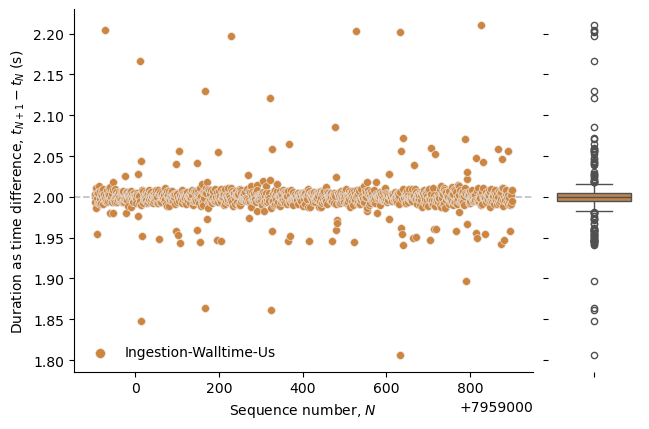

In [22]:
fig, axs = plt.subplots(1, 2, figsize=figure_size, dpi=figure_dpi, width_ratios=(5, 1), sharey=True)
ax1, ax2 = axs

# Axis 1
sns.scatterplot(
    ax=ax1,
    x=audio_data.index,
    y=discrete_diff(video_data["Ingestion-Walltime-Us"]),
    s=32,
    color="peru",
    edgecolor="0.9",
    label="Ingestion-Walltime-Us"
)

ax1.xaxis.set_major_formatter(PlainOffsetScalarFormatter(7.959e6))

ax1.axhline(SEGMENT_DURATION, ls="--", lw=1.25, color="silver", zorder=0)

ax1.set_xlabel("Sequence number, $N$")
ax1.set_ylabel("Duration as time difference, $t_{N + 1} - t_N$ (s)")

sns.despine(ax=ax1)

ax1.legend(frameon=False, ncol=1, markerscale=1.25)


# Axis 2
sns.boxplot(
    ax=ax2,
    y=discrete_diff(video_data["Ingestion-Walltime-Us"]),
    fliersize=4.5,
    color="peru"
)

sns.despine(ax=ax2, bottom=True, left=True)


plt.tight_layout()
plt.show()

In [23]:
discrete_diff(video_data["Ingestion-Walltime-Us"]).describe()

count   999.000000
mean      2.000154
std       0.023637
min       1.805853
25%       1.995274
50%       2.000211
75%       2.004372
max       2.210040
Name: Ingestion-Walltime-Us, dtype: float64

### Stream-Duration-Us values

In [24]:
METADATA_COLUMNS = ["Ingestion-Walltime-Us", "Stream-Duration-Us"]

video_diff_data = discrete_diff(video_data[METADATA_COLUMNS])

unique_stream_durations = video_diff_data["Stream-Duration-Us"].unique()
print("Unique values: ", unique_stream_durations)

selected_by_stream_durations = video_diff_data[
    video_diff_data["Stream-Duration-Us"].isin(unique_stream_durations[[1, 2]])
]
display(selected_by_stream_durations)

Unique values:  [2.    2.066 1.934   nan]


,Ingestion-Walltime-Us,Stream-Duration-Us
sequence,,
7959642,1.998641,2.066000
7959643,1.998790,1.934000


### Actual segment durations

In [25]:
audio_data

,Ingestion-Walltime-Us,Stream-Duration-Us,duration
sequence,,,
7958903,1679786800.444501,15917399.539000,1.996916
7958904,1679786802.443910,15917401.539000,1.996916
7958905,1679786804.447300,15917403.539000,1.996916
7958906,1679786806.440396,15917405.539000,1.996916
7958907,1679786808.451086,15917407.539000,2.020136
...,...,...,...
7959898,1679788790.602439,15919389.539000,1.996916
7959899,1679788792.594128,15919391.539000,1.996916
7959900,1679788794.595797,15919393.539000,1.996916


/tmp/ipykernel_70980/184610779.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["Audio", "Video"])


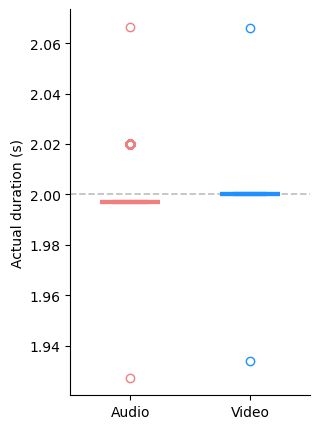

In [26]:
w, h = figure_size
fig, ax = plt.subplots(1, 1, figsize=(w * 0.5, h), dpi=figure_dpi) 

sns.boxplot(audio_data, x=0, y="duration", ax=ax, linewidth=3, linecolor=AUDIO_COLOR, width=0.5)
sns.boxplot(video_data, x=1, y="duration", ax=ax, linewidth=3, linecolor=VIDEO_COLOR, width=0.5)

ax.axhline(SEGMENT_DURATION, ls="--", lw=1.25, color="silver", zorder=0)

ax.set_xticklabels(["Audio", "Video"])

ax.set_ylabel("Actual duration (s)")

sns.despine(ax=ax)

plt.tight_layout()
plt.show()

#### Video segments

In [27]:
unique_video_durations = video_data["duration"].unique()
print("Unique values: ", unique_video_durations)
video_selected_by_durations = video_data[video_data["duration"].isin(unique_video_durations[1:])]
display(video_selected_by_durations)

Unique values:  [2.    2.066 1.934]


,Ingestion-Walltime-Us,Stream-Duration-Us,duration
sequence,,,
7959639,1679788272.575379,15918871.539000,2.066000
7959640,1679788274.647494,15918873.539000,1.934000


In [28]:
start_index = video_selected_by_durations.index[0] - 2
around_video_selected_by_durations = video_data.loc[start_index:start_index + 9]
display(
    pd.concat(
        [
            discrete_diff(around_video_selected_by_durations[METADATA_COLUMNS]),
            video_data["duration"].loc[around_video_selected_by_durations.index],
        ],
        axis=1
    )
)

,Ingestion-Walltime-Us,Stream-Duration-Us,duration
sequence,,,
7959637,1.954343,2.000000,2.000000
7959638,1.997883,2.000000,2.000000
7959639,2.072115,2.000000,2.066000
7959640,1.941375,2.000000,1.934000
7959641,2.010036,2.000000,2.000000
7959642,1.998641,2.066000,2.000000
7959643,1.998790,1.934000,2.000000
7959644,1.992364,2.000000,2.000000
7959645,2.003832,2.000000,2.000000


#### Audio segments

In [29]:
unique_audio_durations = audio_data["duration"].unique()
print("Unique values: ", unique_audio_durations)
audio_selected_by_durations = audio_data[audio_data["duration"].isin(unique_audio_durations[2:])]
display(audio_selected_by_durations)

Unique values:  [1.996916 2.020136 2.066576 1.927256]


,Ingestion-Walltime-Us,Stream-Duration-Us,duration
sequence,,,
7959639,1679788272.575379,15918871.539000,2.066576
7959640,1679788274.647494,15918873.539000,1.927256


In [30]:
start_index = audio_selected_by_durations.index[0] - 2
around_audio_selected_by_durations = audio_data.loc[start_index:start_index + 9]
display(
    pd.concat(
        [
            discrete_diff(around_audio_selected_by_durations[METADATA_COLUMNS]),
            audio_data["duration"].loc[around_audio_selected_by_durations.index],
        ],
        axis=1
    )
)

,Ingestion-Walltime-Us,Stream-Duration-Us,duration
sequence,,,
7959637,1.954343,2.000000,1.996916
7959638,1.997883,2.000000,2.020136
7959639,2.072115,2.000000,2.066576
7959640,1.941375,2.000000,1.927256
7959641,2.010036,2.000000,1.996916
7959642,1.998641,2.066000,1.996916
7959643,1.998790,1.934000,1.996916
7959644,1.992364,2.000000,1.996916
7959645,2.003832,2.000000,2.020136


## Part 2. Focusing on 100 segments

In [31]:
region_slice = slice(7959530, 7959630)
A = audio_data.loc[region_slice]
V = video_data.loc[region_slice]

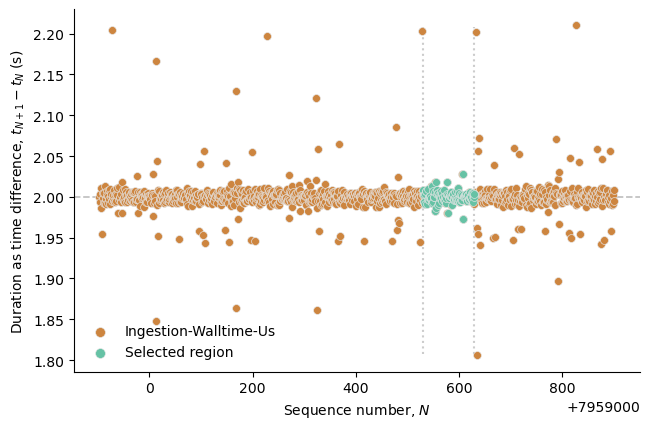

In [32]:
fig, ax = plt.subplots(1, 1, figsize=figure_size, dpi=figure_dpi)


sns.scatterplot(
    x=audio_data.index,
    y=discrete_diff(audio_data["Ingestion-Walltime-Us"]),
    color="peru",
    edgecolor="0.9",
    s=32,
    label="Ingestion-Walltime-Us"
)
sns.scatterplot(
    x=V.index,
    y=V["Ingestion-Walltime-Us"].diff(),
    color="C0",
    edgecolor="0.9",
    s=32,
    label="Selected region"
)

ax.axhline(SEGMENT_DURATION, ls="--", lw=1.25, color="silver", zorder=0)

ax.axvline(V.index[0], ls=":", c="0.8", zorder=0, ymin=0.05, ymax=0.95)
ax.axvline(V.index[-1], ls=":", c="0.8", zorder=0, ymin=0.05, ymax=0.95)

ax.set_xlabel("Sequence number, $N$")
ax.set_ylabel("Duration as time difference, $t_{N + 1} - t_N$ (s)")

ax.xaxis.set_major_formatter(PlainOffsetScalarFormatter(7.959e6))

sns.despine(ax=ax)

plt.legend(frameon=False, ncol=1, markerscale=1.25)


plt.tight_layout()
plt.show()

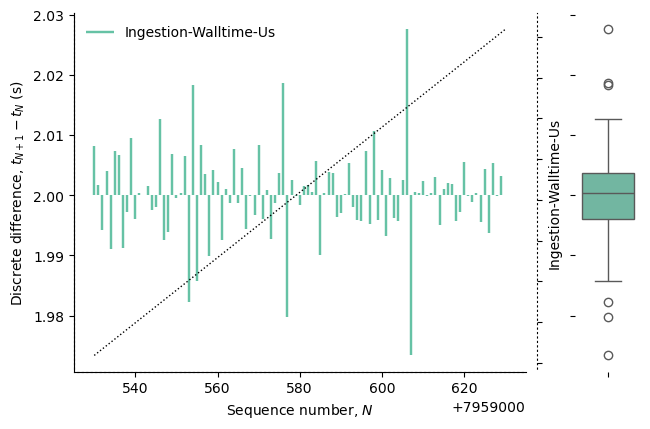

In [33]:
fig, axs = plt.subplots(1, 2, figsize=figure_size, dpi=figure_dpi, width_ratios=(7, 1), sharey=True) 

ax, axr = axs


# Main axis
ax.vlines(
    x=V.index,
    ymin=2,
    ymax=discrete_diff(V["Ingestion-Walltime-Us"]),
    colors="C0",
    lw=1.75,
    label="Ingestion-Walltime-Us"
)

ax.set_xlabel("Sequence number, $N$")
ax.set_ylabel("Discrete difference, $t_{N + 1} - t_N$ (s)")

ax.legend(frameon=False, loc=2)

ax.xaxis.set_major_formatter(PlainOffsetScalarFormatter(7.959e6))

sns.despine(ax=ax)


# Secondary axis
ax2 = ax.twinx()

ax2.plot(V.index, V["Ingestion-Walltime-Us"], ls=":", c="k", lw=1)

ax2.tick_params(axis="y", which="both", right=True, labelright=False)
ax2.set_ylabel("Ingestion-Walltime-Us")

sns.despine(ax=ax2, right=False)
ax2.spines.right.set_position(("axes", 1.025))
for spine in ax2.spines.values():
    spine.set_linestyle((1, (1, 3)))

    
# Right axis
sns.boxplot(ax=axr, data=discrete_diff(V["Ingestion-Walltime-Us"]))
sns.despine(ax=axr, bottom=True, left=True)


plt.tight_layout()
plt.show()

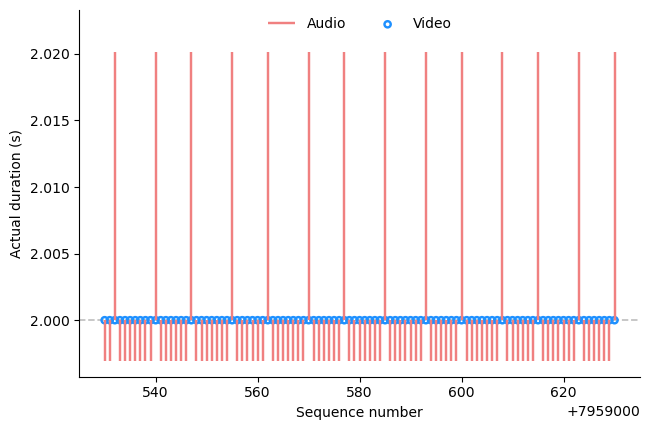

In [34]:
fig, ax = plt.subplots(1, 1, figsize=figure_size, dpi=figure_dpi)

ax.vlines(A.index, ymin=2, ymax=A["duration"], colors=AUDIO_COLOR, ls="-", lw=1.75, label="Audio")
ax.scatter(V.index, V["duration"], c="none", edgecolors=VIDEO_COLOR, lw=1.75, s=20, label="Video")

ax.axhline(SEGMENT_DURATION, ls="--", lw=1.25, color="silver", zorder=0)

ax.xaxis.set_major_formatter(PlainOffsetScalarFormatter(7.959e6))

sns.despine()

ax.set_xlabel("Sequence number")
ax.set_ylabel("Actual duration (s)")

plt.ylim(plt.ylim()[0], plt.ylim()[1] + 0.002)
plt.legend(frameon=False, ncol=2, loc=9, borderpad=0)

plt.tight_layout()

plt.show()

In [35]:
frames_per_sample = 1024
sample_per_second = 44100
frame_duration = frames_per_sample / sample_per_second
print(f"1 frame = {frame_duration:f} s")
print()

1 frame = 0.023220 s



In [36]:
number_of_frames = pd.Series(np.round(A["duration"].values / frame_duration, 5))

number_of_frames_groups = np.array(
    [(x, len(list(y))) for (x, y) in groupby(number_of_frames)]
)
group_first_indices = np.cumsum(np.concatenate([[0], number_of_frames_groups[:,1]]))[:-1] + region_slice.start 

print("Audio segments grouped by number of frames:\n")
print("First occurence, number of frames per segment, counts")
with np.printoptions(threshold=999):
    print(np.column_stack([group_first_indices, number_of_frames_groups]).astype(int))

Audio segments grouped by number of frames:

First occurence, number of frames per segment, counts
[[7959530      86       2]
 [7959532      87       1]
 [7959533      86       7]
 [7959540      87       1]
 [7959541      86       6]
 [7959547      87       1]
 [7959548      86       7]
 [7959555      87       1]
 [7959556      86       6]
 [7959562      87       1]
 [7959563      86       7]
 [7959570      87       1]
 [7959571      86       6]
 [7959577      87       1]
 [7959578      86       7]
 [7959585      87       1]
 [7959586      86       7]
 [7959593      87       1]
 [7959594      86       6]
 [7959600      87       1]
 [7959601      86       7]
 [7959608      87       1]
 [7959609      86       6]
 [7959615      87       1]
 [7959616      86       7]
 [7959623      87       1]
 [7959624      86       6]
 [7959630      87       1]]


In [37]:
np.unique(discrete_diff(V["Stream-Duration-Us"]))

array([ 2., nan])

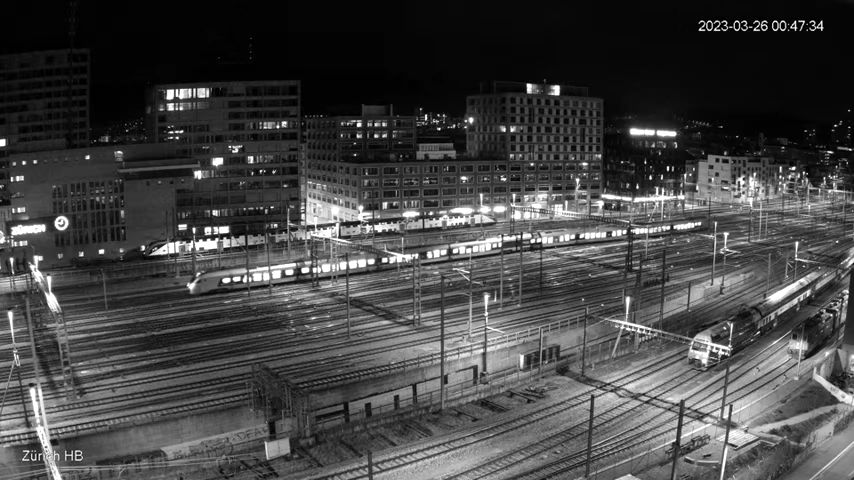

Segment 7959530
  Ingestion-Walltime-Us: 2023-03-26 00:47:34.588652+01:00


In [38]:
sequence = 7959530
display_first_video_frame(SHARED_PATH / "gap-cases" / "1" / f"zur-{sequence}-i244.webm", format="gray")
print(f"Segment {sequence}")
print(
    "  Ingestion-Walltime-Us:",
    datetime.fromtimestamp(V.loc[sequence, "Ingestion-Walltime-Us"], tz=STREAM_TIMEZONE)
)

In [39]:
broadcast_start_date = datetime.fromisoformat("2022-07-15T20:41:12+00:00")

sequence = 7959530
print(f"Segment {sequence}")
print(
    '  meta@itemprop="startDate" + Stream-Duration-Us:',
    broadcast_start_date + timedelta(seconds=V.loc[sequence]["Stream-Duration-Us"])
)

Segment 7959530
  meta@itemprop="startDate" + Stream-Duration-Us: 2023-01-16 02:32:05.539000+00:00


## Part 3. Test points

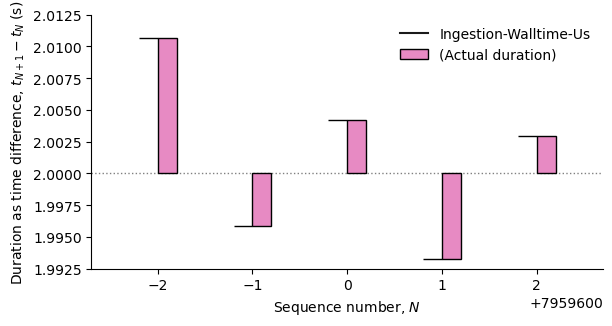

In [40]:
w, h = figure_size
fig, ax = plt.subplots(1, 1, figsize=(w, h * 0.75), dpi=figure_dpi) 

plot_data = V.loc[7959600-2:7959600+3]
plot_hat_graph(
    ax,
    sequences=plot_data.index,
    y1=discrete_diff(plot_data["Ingestion-Walltime-Us"]),
    y2=plot_data["duration"],
    baseline=SEGMENT_DURATION,
    width=0.1
)

plt.ylim(1.9925, 2.0125)

plt.show()

### Selecting points

In [41]:
ingestion_diff = V.loc[7959601, "Ingestion-Walltime-Us"] - V.loc[7959600, "Ingestion-Walltime-Us"]
ingestion_duration_diff = ingestion_diff - V.loc[7959600, "duration"]
y_S2 = V.loc[7959601, "Ingestion-Walltime-Us"] - ingestion_duration_diff / 2
assert y_S2 < V.loc[7959601, "Ingestion-Walltime-Us"]

ingestion_diff = V.loc[7959602, "Ingestion-Walltime-Us"] - V.loc[7959601, "Ingestion-Walltime-Us"]
ingestion_duration_diff = ingestion_diff - V.loc[7959601, "duration"]
y_S3 = V.loc[7959602, "Ingestion-Walltime-Us"] - ingestion_duration_diff / 2
assert y_S3 < V.loc[7959601, "Ingestion-Walltime-Us"] + V.loc[7959601, "duration"]
assert y_S3 > V.loc[7959602, "Ingestion-Walltime-Us"]

points_list = [
    ("S_1/E_1", (7959599.5, np.interp(7959599.5, V.index, V["Ingestion-Walltime-Us"]))),
    ("S_2", interpolate_point(y_S2, V["Ingestion-Walltime-Us"], V.index)[::-1]),
    ("S_3", interpolate_point(y_S3, V["Ingestion-Walltime-Us"], V.index)[::-1]),
]

for label, point in points_list:
    print("{:>14}".format(f"Point {label}:"), f"segment {int(point[0])}, {point[1]:.6f}")

Point S_1/E_1: segment 7959599, 1679788193.600278
    Point S_2: segment 7959600, 1679788196.600287
    Point S_3: segment 7959602, 1679788198.599000


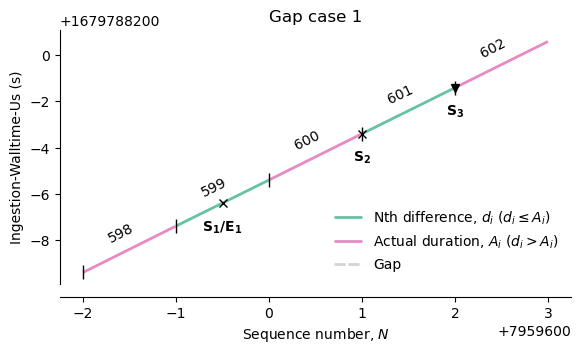

Point S_1/E_1: segment 7959599, 1679788193.600278
    Point S_2: segment 7959600, 1679788196.600287
    Point S_3: segment 7959602, 1679788198.599000


In [42]:
w, h = figure_size

fig, ax = plt.subplots(1, 1, figsize=(w, h * 0.75), dpi=figure_dpi) 

around = 7959600
S = slice(around-2, around+3)

plot_data = V.loc[S]

plot_ingestion_line(ax, plot_data, color="lightcoral")


for label, point in points_list:
    xytext = (0, -20)
    match label:
        case "S_3":
            marker = "v"
        case _:
            marker = "x"
    ax.plot(*point, marker=marker, color="k", mec="k", ms=6, mew=1)
    ax.annotate(f"$\mathbf{{{label}}}$", point, xytext=xytext, textcoords="offset points", ha="center")
    
plt.legend(frameon=False, loc=4)

plt.title("Gap case 1")

plt.show()

for label, point in points_list:
    print("{:>14}".format(f"Point {label}:"), f"segment {int(point[0])}, {point[1]:.6f}")

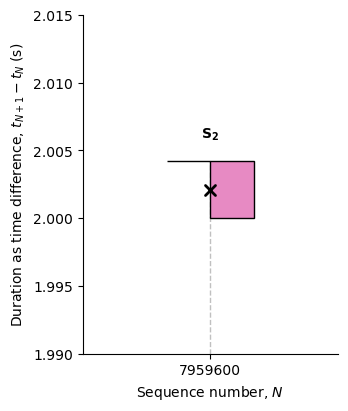

In [43]:
w, h = figure_size
fig, ax = plt.subplots(1, 1, figsize=(w * 0.5, h), dpi=figure_dpi)

plot_data = V.loc[7959600:7959601]
y1, y2 = discrete_diff(plot_data["Ingestion-Walltime-Us"]), plot_data["duration"]
plot_hat_graph(ax, sequences=plot_data.index, y1=y1, y2=y2, width=0.12)

ymin, ymax = 1.99, 2.015
ax.vlines(plot_data.index, ymin=ymin, ymax=y1.fillna(0), lw=1, ls="--", colors="silver", zorder=0)

point = (7959600, y_S2 - plot_data.loc[7959600, "Ingestion-Walltime-Us"])
ax.plot(*point, marker=MarkerStyle('x', capstyle=CapStyle.round), mec="k", mew=2, ms=7)
plt.annotate("$\mathbf{S_2}$", point, xytext=(0, 40), textcoords="offset points", ha="center", va="center")

ax.xaxis.set_major_formatter(FormatStrFormatter("%d"))

plt.xticks([7959600])
plt.ylim(ymin, ymax)

ax.get_legend().remove()

plt.show()

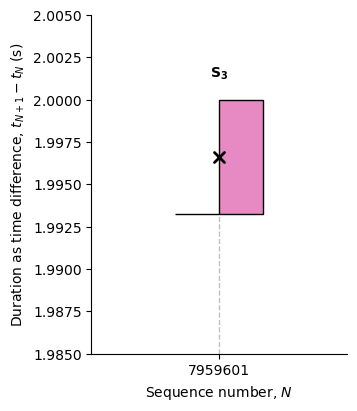

In [44]:
w, h = figure_size
fig, ax = plt.subplots(1, 1, figsize=(w * 0.5, h), dpi=figure_dpi)

plot_data = V.loc[7959601:7959602]
y1, y2 = discrete_diff(plot_data["Ingestion-Walltime-Us"]), plot_data["duration"]
plot_hat_graph(ax, sequences=plot_data.index, y1=y1, y2=y2, width=0.12)

ymin, ymax = 1.985, 2.005
ax.vlines(plot_data.index, ymin=ymin, ymax=y1.fillna(0), lw=1, ls="--", colors="silver", zorder=0)

point = (7959601, y_S3 - plot_data.loc[7959601, "Ingestion-Walltime-Us"])
ax.plot(*point, marker=MarkerStyle('x', capstyle=CapStyle.round), mec="k", mew=2, ms=7)
plt.annotate("$\mathbf{S_3}$", point, xytext=(0, 60), textcoords="offset points", ha="center", va="center")

ax.xaxis.set_major_formatter(FormatStrFormatter("%d"))

plt.xticks([7959601])
plt.ylim(ymin, ymax)

ax.get_legend().remove()

plt.show()

### Exporting fixture data

In [45]:
to_export = V[["Ingestion-Walltime-Us", "duration"]].copy()
to_export["Ingestion-Walltime-Us"] = to_export["Ingestion-Walltime-Us"].apply(lambda x: int(x * 1e6)) 

output_path = Path("./out/gap-cases/gap-case-1-fixture.csv")
output_path.parent.mkdir(parents=True, exist_ok=True)

to_export.to_csv(output_path)
with pd.option_context("display.max_rows", 8):
    display(to_export)

,Ingestion-Walltime-Us,duration
sequence,,
7959530,1679788054588652,2.000000
7959531,1679788056596847,2.000000
7959532,1679788058598541,2.000000
7959533,1679788060592696,2.000000
...,...,...
7959627,1679788248591618,2.000000
7959628,1679788250596887,2.000000
7959629,1679788252596773,2.000000
7959630,1679788254599912,2.000000
